# Time Series with RNN


## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [14]:
milk = pd.read_csv('/home/ubuntu/Downloads/monthly-milk-production-pounds-p.csv',index_col='Month')

** Check out the head of the dataframe**

In [15]:
milk.head()

,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [16]:
milk.index = pd.to_datetime(milk.index)

** Plot out the time series data. **

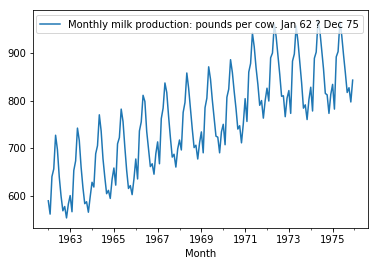

In [17]:
milk.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **
** note we do not do the standard 80/20 since this time series data


In [18]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Monthly milk production: pounds per cow. Jan 62 ? Dec 75    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


In [ ]:
#the data is for 168/12=14 years

In [19]:
#we take the 13 years data for training
train_set = milk.head(156)

In [20]:
13*12

156

In [21]:
#remaining one year data for testing
test_set = milk.tail(12)

### Scale the Data - standard ML process




In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()

In [24]:
train_scaled = scaler.fit_transform(train_set)

In [25]:

test_scaled = scaler.transform(test_set)

## Batch Function



In [26]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Setting Up The RNN Model

** Import TensorFlow **

In [27]:
import tensorflow as tf

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [28]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

** Create Placeholders for X and y.** 

In [29]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

**  RNN Layer.**

#Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [30]:
#Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

Instructions for updating:
Use the retry module or similar alternatives.


# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [31]:
#rolls out the cell
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [32]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [33]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [34]:
saver = tf.train.Saver()

### Session


In [36]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.10041004
100 	MSE: 0.009995961
200 	MSE: 0.007238794
300 	MSE: 0.01365
400 	MSE: 0.006057985
500 	MSE: 0.0086038625
600 	MSE: 0.004559714
700 	MSE: 0.005928773
800 	MSE: 0.005429268
900 	MSE: 0.007167565
1000 	MSE: 0.010100125
1100 	MSE: 0.007974276
1200 	MSE: 0.006212915
1300 	MSE: 0.0070584635
1400 	MSE: 0.0029632654
1500 	MSE: 0.0053449874
1600 	MSE: 0.009315726
1700 	MSE: 0.005733131
1800 	MSE: 0.0060966075
1900 	MSE: 0.002098669
2000 	MSE: 0.007757234
2100 	MSE: 0.00356434
2200 	MSE: 0.0024575533
2300 	MSE: 0.012623017
2400 	MSE: 0.0034101105
2500 	MSE: 0.0043268376
2600 	MSE: 0.0023548484
2700 	MSE: 0.0070621506
2800 	MSE: 0.004918782
2900 	MSE: 0.0017791399
3000 	MSE: 0.0023953419
3100 	MSE: 0.01217876
3200 	MSE: 0.0029990394
3300 	MSE: 0.005899674
3400 	MSE: 0.0044232835
3500 	MSE: 0.0021841573
3600 	MSE: 0.0055903443
3700 	MSE: 0.0034320129
3800 	MSE: 0.004980969
3900 	MSE: 0.007101378


______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [37]:
test_set

,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
Month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

In [38]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [39]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.62725407,
 0.60735947,
 0.69444585,
 0.7131852,
 0.7617049,
 0.801885,
 0.7906959,
 0.79434466,
 0.779461,
 0.78823256,
 0.7916451,
 0.806808]

In [40]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. **

In [41]:
test_set['Generated'] = results

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [42]:
test_set

,Monthly milk production: pounds per cow. Jan 62 ? Dec 75,Generated
Month,,
1975-01-01,834,813.937683
1975-02-01,782,805.661560
1975-03-01,892,841.889465
1975-04-01,903,849.685059
1975-05-01,966,869.869202
1975-06-01,937,886.584167
1975-07-01,896,881.929443
1975-08-01,858,883.447388
1975-09-01,817,877.255798


** Plot out the two columns for comparison. **

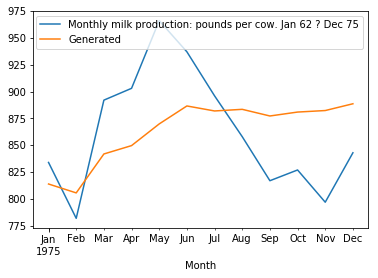

In [43]:
test_set.plot()